# **Notebook 18.1: Diffusion Encoder**

This notebook investigates the diffusion encoder as described in section 18.2 of the book.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from operator import itemgetter

In [2]:
#Create pretty colormap as in book
my_colormap_vals_hex =('2a0902', '2b0a03', '2c0b04', '2d0c05', '2e0c06', '2f0d07', '300d08', '310e09', '320f0a', '330f0b', '34100b', '35110c', '36110d', '37120e', '38120f', '39130f', '3a1410', '3b1411', '3c1511', '3d1612', '3e1613', '3f1713', '401714', '411814', '421915', '431915', '451a16', '461b16', '471b17', '481c17', '491d18', '4a1d18', '4b1e19', '4c1f19', '4d1f1a', '4e201b', '50211b', '51211c', '52221c', '53231d', '54231d', '55241e', '56251e', '57261f', '58261f', '592720', '5b2821', '5c2821', '5d2922', '5e2a22', '5f2b23', '602b23', '612c24', '622d25', '632e25', '652e26', '662f26', '673027', '683027', '693128', '6a3229', '6b3329', '6c342a', '6d342a', '6f352b', '70362c', '71372c', '72372d', '73382e', '74392e', '753a2f', '763a2f', '773b30', '783c31', '7a3d31', '7b3e32', '7c3e33', '7d3f33', '7e4034', '7f4134', '804235', '814236', '824336', '834437', '854538', '864638', '874739', '88473a', '89483a', '8a493b', '8b4a3c', '8c4b3c', '8d4c3d', '8e4c3e', '8f4d3f', '904e3f', '924f40', '935041', '945141', '955242', '965343', '975343', '985444', '995545', '9a5646', '9b5746', '9c5847', '9d5948', '9e5a49', '9f5a49', 'a05b4a', 'a15c4b', 'a35d4b', 'a45e4c', 'a55f4d', 'a6604e', 'a7614e', 'a8624f', 'a96350', 'aa6451', 'ab6552', 'ac6552', 'ad6653', 'ae6754', 'af6855', 'b06955', 'b16a56', 'b26b57', 'b36c58', 'b46d59', 'b56e59', 'b66f5a', 'b7705b', 'b8715c', 'b9725d', 'ba735d', 'bb745e', 'bc755f', 'bd7660', 'be7761', 'bf7862', 'c07962', 'c17a63', 'c27b64', 'c27c65', 'c37d66', 'c47e67', 'c57f68', 'c68068', 'c78169', 'c8826a', 'c9836b', 'ca846c', 'cb856d', 'cc866e', 'cd876f', 'ce886f', 'ce8970', 'cf8a71', 'd08b72', 'd18c73', 'd28d74', 'd38e75', 'd48f76', 'd59077', 'd59178', 'd69279', 'd7937a', 'd8957b', 'd9967b', 'da977c', 'da987d', 'db997e', 'dc9a7f', 'dd9b80', 'de9c81', 'de9d82', 'df9e83', 'e09f84', 'e1a185', 'e2a286', 'e2a387', 'e3a488', 'e4a589', 'e5a68a', 'e5a78b', 'e6a88c', 'e7aa8d', 'e7ab8e', 'e8ac8f', 'e9ad90', 'eaae91', 'eaaf92', 'ebb093', 'ecb295', 'ecb396', 'edb497', 'eeb598', 'eeb699', 'efb79a', 'efb99b', 'f0ba9c', 'f1bb9d', 'f1bc9e', 'f2bd9f', 'f2bfa1', 'f3c0a2', 'f3c1a3', 'f4c2a4', 'f5c3a5', 'f5c5a6', 'f6c6a7', 'f6c7a8', 'f7c8aa', 'f7c9ab', 'f8cbac', 'f8ccad', 'f8cdae', 'f9ceb0', 'f9d0b1', 'fad1b2', 'fad2b3', 'fbd3b4', 'fbd5b6', 'fbd6b7', 'fcd7b8', 'fcd8b9', 'fcdaba', 'fddbbc', 'fddcbd', 'fddebe', 'fddfbf', 'fee0c1', 'fee1c2', 'fee3c3', 'fee4c5', 'ffe5c6', 'ffe7c7', 'ffe8c9', 'ffe9ca', 'ffebcb', 'ffeccd', 'ffedce', 'ffefcf', 'fff0d1', 'fff2d2', 'fff3d3', 'fff4d5', 'fff6d6', 'fff7d8', 'fff8d9', 'fffada', 'fffbdc', 'fffcdd', 'fffedf', 'ffffe0')
my_colormap_vals_dec = np.array([int(element,base=16) for element in my_colormap_vals_hex])
r = np.floor(my_colormap_vals_dec/(256*256))
g = np.floor((my_colormap_vals_dec - r *256 *256)/256)
b = np.floor(my_colormap_vals_dec - r * 256 *256 - g * 256)
my_colormap_vals = np.vstack((r,g,b)).transpose()/255.0
my_colormap = ListedColormap(my_colormap_vals)

In [3]:
# Probability distribution for normal
def norm_pdf(x, mu, sigma):
    return np.exp(-0.5 * (x-mu)**2 / (sigma * sigma)) / np.sqrt(2*np.pi*sigma*sigma)

In [4]:
# True distribution is a mixture of four Gaussians
class TrueDataDistribution:
  # Constructor initializes parameters
  def __init__(self):
    self.mu = [1.5, -0.216, 0.45, -1.875]
    self.sigma = [0.3, 0.15, 0.525, 0.075]
    self.w = [0.2, 0.3, 0.35, 0.15]

  # Return PDF
  def pdf(self, x):
    return(self.w[0] *norm_pdf(x,self.mu[0],self.sigma[0]) +  self.w[1] *norm_pdf(x,self.mu[1],self.sigma[1]) + self.w[2] *norm_pdf(x,self.mu[2],self.sigma[2]) + self.w[3] *norm_pdf(x,self.mu[3],self.sigma[3]))

  # Draw samples
  def sample(self, n):
    hidden = np.random.choice(4, n, p=self.w)
    epsilon = np.random.normal(size=(n))
    mu_list = list(itemgetter(*hidden)(self.mu))
    sigma_list = list(itemgetter(*hidden)(self.sigma))
    return mu_list + sigma_list * epsilon

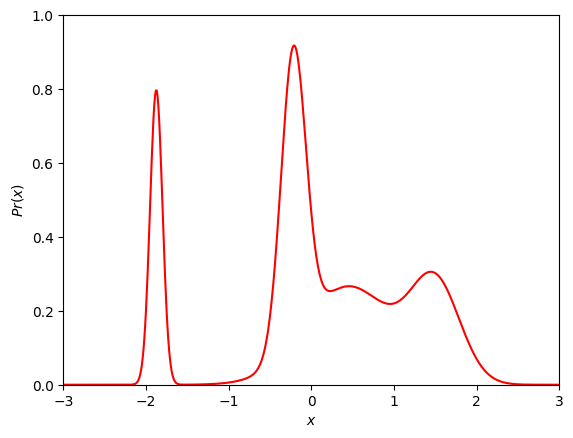

In [5]:
# Define ground truth probability distribution that we will model
true_dist = TrueDataDistribution()
# Let's visualize this
x_vals = np.arange(-3,3,0.01)
pr_x_true = true_dist.pdf(x_vals)
fig,ax = plt.subplots()
ax.plot(x_vals, pr_x_true, 'r-')
ax.set_xlabel("$x$")
ax.set_ylabel("$Pr(x)$")
ax.set_ylim(0,1.0)
ax.set_xlim(-3,3)
plt.show()

Let's first implement the forward process

In [7]:
# Do one step of diffusion (equation 18.1)
def diffuse_one_step(z_t_minus_1, beta_t):
  # TODO -- Implement this function
  # Use np.random.normal to generate the samples epsilon
  # Replace this line
  N = len(z_t_minus_1)
  epsilon = np.random.normal(size=(N))

  z_t = np.sqrt(1-beta_t) * z_t_minus_1 + np.sqrt(beta_t) * epsilon

  return z_t

Now let's run the diffusion process for a whole bunch of samples

In [8]:
# Generate some samples
n_sample = 10000
np.random.seed(6)
x = true_dist.sample(n_sample)

# Number of time steps
T = 100
# Noise schedule has same value at every time step
beta = 0.01511

# We'll store the diffused samples in an array
samples = np.zeros((T+1, n_sample))
samples[0,:] = x

for t in range(T):
  samples[t+1,:] = diffuse_one_step(samples[t,:], beta)

Let's, plot the evolution of a few paths as in figure 18.2

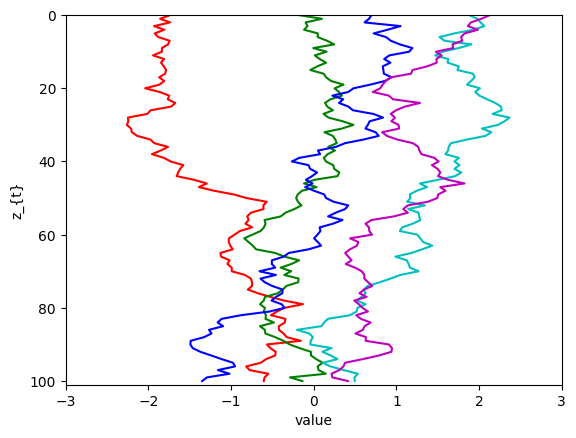

In [13]:
fig, ax = plt.subplots()
t_vals = np.arange(0,101,1)
ax.plot(samples[:,0],t_vals,'r-')
ax.plot(samples[:,1],t_vals,'g-')
ax.plot(samples[:,2],t_vals,'b-')
ax.plot(samples[:,3],t_vals,'c-')
ax.plot(samples[:,4],t_vals,'m-')
ax.set_xlim([-3,3])
ax.set_ylim([101, 0])
ax.set_xlabel('value')
ax.set_ylabel('z_{t}')
plt.show()

Notice that the samples have a tendency to move toward the center.  Now let's look at the histogram of the samples at each stage

In [10]:
def draw_hist(z_t,title=''):
  fig, ax = plt.subplots()
  fig.set_size_inches(8,2.5)
  plt.hist(z_t , bins=np.arange(-3,3, 0.1), density = True)
  ax.set_xlim([-3,3])
  ax.set_ylim([0,1.0])
  ax.set_title(title)
  plt.show()

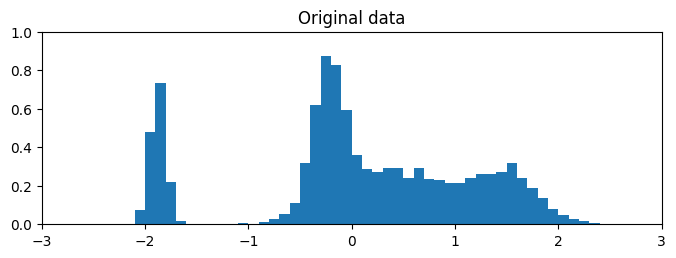

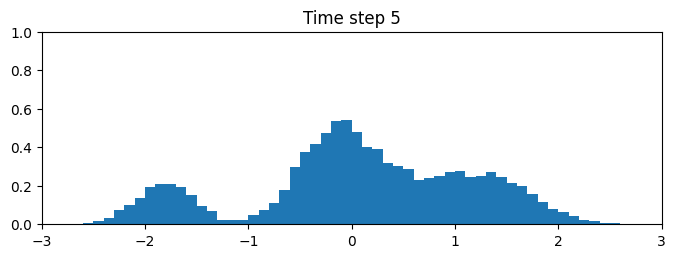

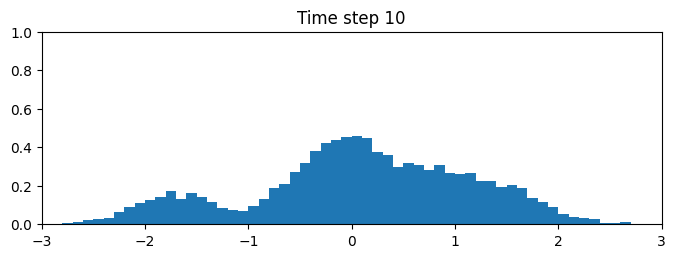

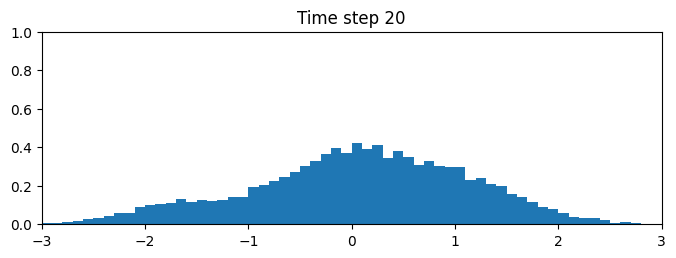

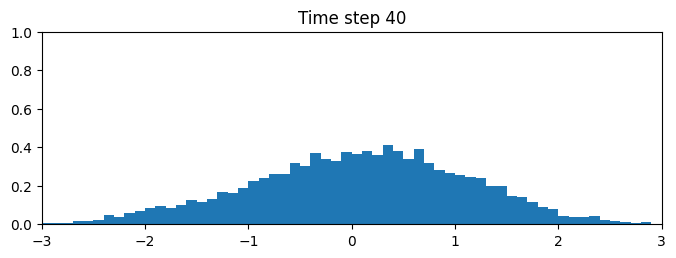

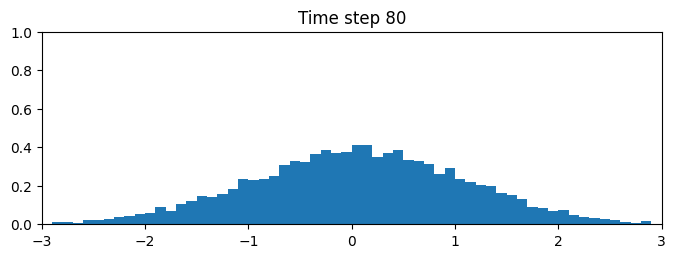

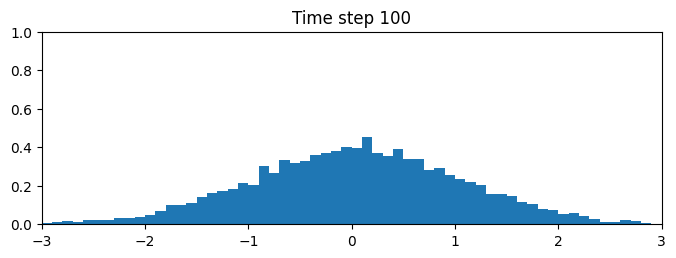

In [11]:
draw_hist(samples[0,:],'Original data')
draw_hist(samples[5,:],'Time step 5')
draw_hist(samples[10,:],'Time step 10')
draw_hist(samples[20,:],'Time step 20')
draw_hist(samples[40,:],'Time step 40')
draw_hist(samples[80,:],'Time step 80')
draw_hist(samples[100,:],'Time step 100')

You can clearly see that as the diffusion process continues, the data becomes more Gaussian.

Now let's investigate the diffusion kernel as in figure 18.3 of the book.


### Time step
\begin{equation}
  X_t = \sqrt{(1-\beta)^t} * x_0 + \sqrt{(1-(1-\beta)^t}.\epsilon
\end{equation}

Implement eq 18.6

In [68]:
def diffusion_kernel(x, t, beta):
  # TODO -- write this function
  # Replace this line:
  dk_mean = np.sqrt((1 - beta)**t) * x
  dk_std = np.sqrt((1-(1-beta)**t))

  return dk_mean, dk_std

In [69]:
def draw_prob_dist(x_plot_vals, prob_dist, title=''):
  fig, ax = plt.subplots()
  fig.set_size_inches(8,2.5)
  ax.plot(x_plot_vals, prob_dist, 'b-')
  ax.set_xlim([-3,3])
  ax.set_ylim([0,1.0])
  ax.set_title(title)
  plt.show()

def compute_and_plot_diffusion_kernels(x, T, beta, my_colormap):
    x_plot_vals = np.arange(-3,3,0.01)
    diffusion_kernels = np.zeros((T+1,len(x_plot_vals)))
    dk_mean_all = np.ones((T+1,1))*x
    dk_std_all = np.zeros((T+1,1))
    for t in range(T):
      dk_mean_all[t+1], dk_std_all[t+1] = diffusion_kernel(x,t+1,beta)
      diffusion_kernels[t+1,:] =  norm_pdf(x_plot_vals, dk_mean_all[t+1], dk_std_all[t+1])

    samples = np.ones((T+1, 5))
    samples[0,:] = x

    for t in range(T):
      samples[t+1,:] = diffuse_one_step(samples[t,:], beta)

    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)

    # Plot the image containing all the kernels
    plt.imshow(diffusion_kernels, cmap=my_colormap, interpolation='nearest')

    # Plot +/- 2 standard deviations
    ax.plot((dk_mean_all -2 * dk_std_all)/0.01 + len(x_plot_vals)/2, np.arange(0,101,1),'y--')
    ax.plot((dk_mean_all +2 * dk_std_all)/0.01 + len(x_plot_vals)/2, np.arange(0,101,1),'y--')

    # Plot a few trajectories
    ax.plot(samples[:,0]/0.01 + + len(x_plot_vals)/2, np.arange(0,101,1), 'r-')
    ax.plot(samples[:,1]/0.01 + + len(x_plot_vals)/2, np.arange(0,101,1), 'g-')
    ax.plot(samples[:,2]/0.01 + + len(x_plot_vals)/2, np.arange(0,101,1), 'b-')
    ax.plot(samples[:,3]/0.01 + + len(x_plot_vals)/2, np.arange(0,101,1), 'c-')
    ax.plot(samples[:,4]/0.01 + + len(x_plot_vals)/2, np.arange(0,101,1), 'm-')

    # Tidy up and plot
    ax.set_ylabel("$Pr(z_{t}|x)$")
    ax.get_xaxis().set_visible(False)
    ax.set_xlim([0,601])
    ax.set_aspect(601/T)
    plt.show()


    draw_prob_dist(x_plot_vals, diffusion_kernels[20,:],'$q(z_{20}|x)$')
    draw_prob_dist(x_plot_vals, diffusion_kernels[40,:],'$q(z_{40}|x)$')
    draw_prob_dist(x_plot_vals, diffusion_kernels[80,:],'$q(z_{80}|x)$')

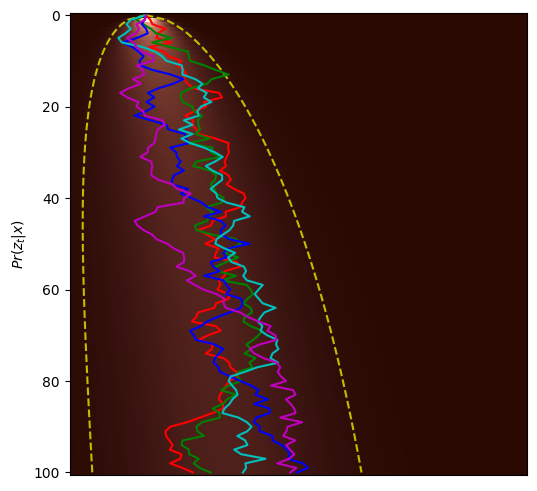

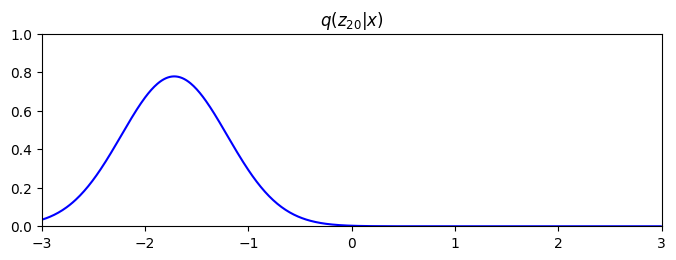

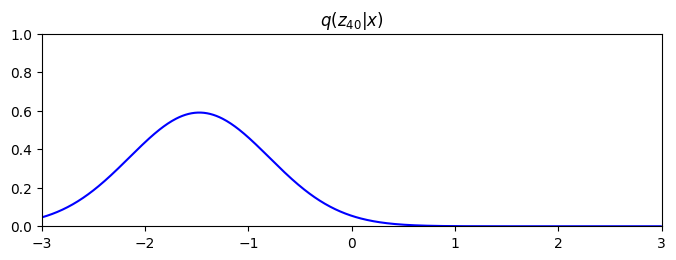

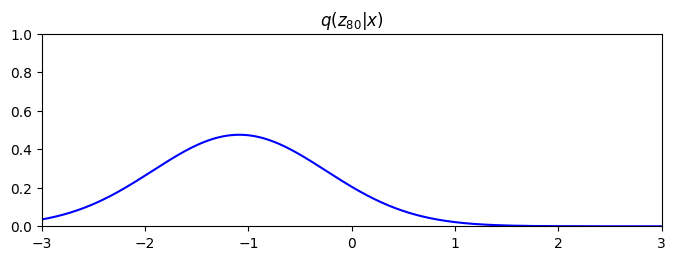

In [70]:
x = -2
compute_and_plot_diffusion_kernels(x, T, beta, my_colormap)

TODO -- Run this for different version of $x$ and check that you understand how the graphs change

Finally, let's estimate the marginal distributions empirically and visualize them as in figure 18.4 of the book. This is only tractable because the data is in one dimension and we know the original distribution.

The marginal distribution at time t is the sum of the diffusion kernels for each position x, weighted by the probability of seeing that value of x in the true distribution.

In [91]:
def diffusion_marginal(x_plot_vals, pr_x_true, t, beta):
    # If time is zero then marginal is just original distribution
    if t == 0:
        return pr_x_true

    # The thing we are computing
    marginal_at_time_t = np.zeros_like(pr_x_true);

    # TODO Write this function
    # 1. For each x (value in x_plot_vals):
    for idx,x  in enumerate(x_plot_vals):
      # 2. Compute the mean and variance of the diffusion kernel at time t
      mean, variance = diffusion_kernel(x, t, beta)

      # 3. Compute pdf of this Gaussian using mean and variansce
      pdf = norm_pdf(x_plot_vals, mean, variance)

      # 4. Weight Gaussian by probability at position x and by 0.01 to componensate for bin size
      weighted_pdf =  pr_x_true[idx] * 0.01

      # 5. Accumulate weighted Gaussian in marginal at time t.
      marginal_at_time_t += weighted_pdf * pdf

    return marginal_at_time_t

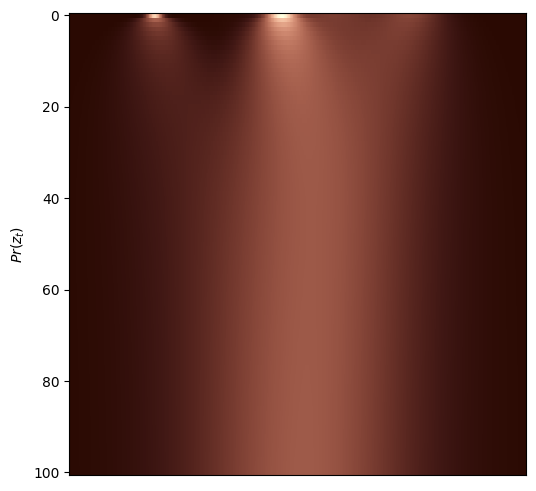

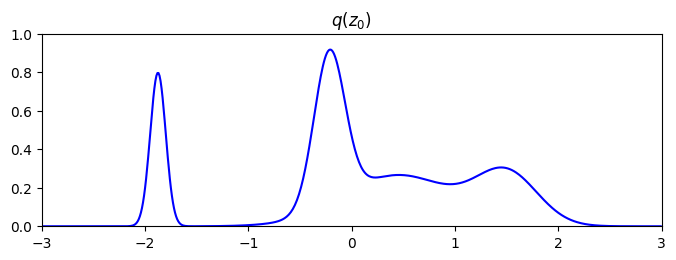

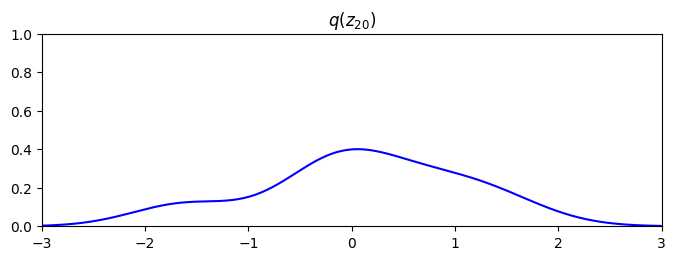

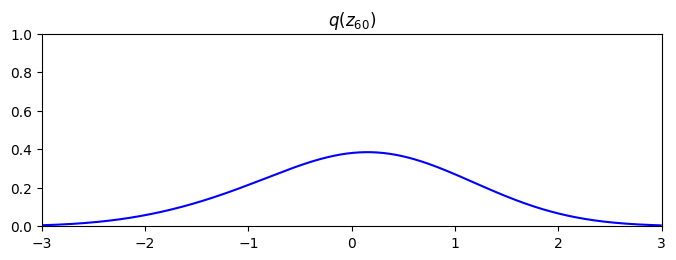

In [92]:
x_plot_vals = np.arange(-3,3,0.01)
marginal_distributions = np.zeros((T+1,len(x_plot_vals)))

for t in range(T+1):
  marginal_distributions[t,:] = diffusion_marginal(x_plot_vals, pr_x_true , t, beta)

fig, ax = plt.subplots()
fig.set_size_inches(6,6)

# Plot the image containing all the kernels
plt.imshow(marginal_distributions, cmap=my_colormap, interpolation='nearest')

# Tidy up and plot
ax.set_ylabel("$Pr(z_{t})$")
ax.get_xaxis().set_visible(False)
ax.set_xlim([0,601])
ax.set_aspect(601/T)
plt.show()


draw_prob_dist(x_plot_vals, marginal_distributions[0,:],'$q(z_{0})$')
draw_prob_dist(x_plot_vals, marginal_distributions[20,:],'$q(z_{20})$')
draw_prob_dist(x_plot_vals, marginal_distributions[60,:],'$q(z_{60})$')